# CS 109A - Intro to Data Science: Project (WIP)
## Predicting Loan Outcomes
## Group: Andrew Greene and David Modjeska
### Harvard University, Fall 2016

In [1]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import re
import scipy as sp
import sklearn.preprocessing as Preprocessing

import enchant

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN

%matplotlib inline

## Step 1: Clean Data

In [2]:
# helper function to select the columns of interest from the data set
def Select_Data(data):
    
    # list columns to select
    features_to_select = ["loan_status", "annual_inc", "earliest_cr_line", "delinq_2yrs", \
                          "emp_length", "home_ownership", "inq_last_6mths", "loan_amnt", \
                         "purpose", "open_acc", "total_acc", "term", "installment", \
                         "revol_bal", "sub_grade", "issue_d"]
    ratios_to_select = ["dti", "revol_util"]
    text_to_select = ["desc"]

    # concatenate selected columns
    data_select = pd.concat(( \
                            data[features_to_select],
                            data[ratios_to_select], \
                            data[text_to_select]), \
                            axis = 1)

    # synthesize new columns, and drop temporary columns
    monthly_inc = (data["annual_inc"] / 12)
    data_select["ipr"] = data["installment"] / monthly_inc # income to payment ratio
    data_select["rir"] = data["revol_bal"] / monthly_inc # revolving to income ratio
    data_select = data_select.drop("installment", axis = 1)
    data_select = data_select.drop("revol_bal", axis = 1)
    
    # rename columns for legibility
    data_select.columns = [
        "loan_status", "annual_income", "earliest_credit", "delinq_2_yrs", \
        "employ_length", "home_owner", "inquiry_6_mos", "loan_amount", \
        "loan_purpose", "open_accounts", "total_acccounts", "loan_term", \
        "loan_subgrade", "issue_date", "dti", "revol_util", "description", \
        "ipr", "rir" \
    ]
    
    return data_select

In [3]:
# helper function to filter the data set down to rows of interest
def Filter_Data(data_select):
    
    # set flags for resolved loans
    status_indexes = (data_select["loan_status"] == "Fully Paid") | \
                    (data_select["loan_status"] == "Charged Off")

    # set flags for date range of interest
    earliest_date = pd.to_datetime("2008-01-01")
    data_my = pd.to_datetime(data_select["issue_date"])
    date_indexes = (data_my > earliest_date)

    # filter rows per flags of interest
    data_filter = data_select.ix[status_indexes & date_indexes, :].reset_index()
    data_filter = data_filter.drop("issue_date", axis = 1)
    
    return data_filter

In [4]:
# helper function to clean data - recoding, retyping, pruning, and censoring
def Clean_Data(data_filter):
    data_clean = data_filter.copy()

    # recode loan status as boolean: fully paid = True
    data_clean["loan_status"] = data_clean["loan_status"] == "Fully Paid"

    # recode loan subgrades from 1 (best) to 35 (worst)
    num_grades = 5
    grade = data_clean["loan_subgrade"].str[0]
    grade = (pd.DataFrame(ord(c) for c in grade) - ord('A')) * num_grades
    sub_grade = data_clean["loan_subgrade"].str[1].astype('int')
    data_clean["loan_subgrade"] =  grade + sub_grade

    # convert earliest credit date to datetime
    data_clean["earliest_credit"] = pd.to_datetime(data_clean["earliest_credit"])

    # prune extra text in loan term 
    data_clean["loan_term"] = data_clean["loan_term"].str.replace(" months", "")

    # prune extra text in employment length, and right-censor
    data_clean["employ_length"] = data_clean["employ_length"].str.replace(" years*", "")
    data_clean["employ_length"] = data_clean["employ_length"].str.replace("10\+", "10")
    data_clean["employ_length"] = data_clean["employ_length"].str.replace("< 1", "0")
    
    # right-censor delinquencies and inquiries
    data_clean["delinq_2_yrs"] = np.clip(data_clean["delinq_2_yrs"], 0, 2)
    data_clean["inquiry_6_mos"] = np.clip(data_clean["inquiry_6_mos"], 0, 3)
    
    return data_clean

In [5]:
# helper function to clean data - filtering nuisance NaNs (not structural NaNs)
def Clean_Data2(data_clean):
    n, p = data_clean.shape
    
    # count nulls by column
    col_nan_pct = data_clean.isnull().sum() / n
    
    # flag columns that have some nuisance nulls
    cols_with_nans = (col_nan_pct > 0.0) & (col_nan_pct < 0.01)
    
    # flag rows that have some nuisance nulls in the flagged columns
    rows_without_nans_flags = data_clean.ix[:, cols_with_nans].notnull()
    
    # index the flagged rows with some nuisance nulls
    rows_without_nans_indexes = np.where(rows_without_nans_flags)
    
    # filter the data set to rows with no nuisance nulls
    data_clean2 = data_clean.ix[rows_without_nans_indexes[0], :]
    
    return data_clean2

In [6]:
# helper function to pre-process each data subset to get around memory limits
def Prep_Data_Part(index, num_parts, file_prefix, data_all):
    filename = file_prefix + str(index) + ".csv"
    
    # pre-process new data part if the file doesn't already exist
    if not op.isfile(filename):
        n, p = data_all.shape
        
        # pre-process the row range for this data part, avoiding empty data subsets
        start_row = index * (n / num_parts)
        data_part = data_all.ix[range(start_row, start_row + (n / num_parts)), :]
        if data_part.shape[0] > 0:
            data_select = Select_Data(data_part)
            data_filter = Filter_Data(data_select)
            if data_filter.shape[0] > 0:
                data_clean = Clean_Data(data_filter)
                data_clean2 = Clean_Data2(data_clean)
                data_clean2.to_csv(filename, index = False)

In [7]:
# helper function to pre-process full data set and save new file, 
# or to read pre-processed file if it already exists
def Preprocess_Full_Dataset():
    file_prefix = "./data_parts/loan_clean_part"
    full_clean_data_file = "loan_clean_data.csv"
    num_parts = 30

    # pre-process data set and save result as new file
    if not op.isfile(full_clean_data_file):

        # pre-process and save part files
        data_raw = pd.read_csv("loan.csv")
        for part in range(num_parts):
            Prep_Data_Part(part, num_parts, file_prefix, data_raw)       

        # read and concatenate part files
        data = pd.DataFrame({})
        for part in range(num_parts):
            file_part = file_prefix + str(part) + ".csv"
            if op.isfile(file_part):
                data_part = pd.read_csv(file_part)
                data = pd.concat((data, data_part), axis = 0)

        # save full file
        data = data.reset_index()
        data.to_csv(full_clean_data_file, index = False)

    # read pre-processed full data file
    else:
        data = pd.read_csv(full_clean_data_file)
        
    return data

In [8]:
# helper function to pre-process sampled data set and save new file, 
# or to read pre-processed file if it already exists
def Preprocess_Sample_Dataset():
    sample_percent = 10
    sample_clean_data_file = "loan_clean_data_" + str(sample_percent) + "pct.csv"

    # pre-process sample data set and save result as new file
    if not op.isfile(sample_clean_data_file):
        data_raw = pd.read_csv("loan.csv")
        data_sample, data_other = sk_split(data_raw, train_size = sample_percent / 100.0)
        data_select = Select_Data(data_sample)
        data_filter = Filter_Data(data_select)
        data_clean = Clean_Data(data_filter)
        data_clean2 = Clean_Data2(data_clean)
        data_clean2.to_csv(sample_clean_data_file, index = False)

    # read pre-processed sample data file
    else:
        data_clean2 = pd.read_csv(sample_clean_data_file)
        
    return data_clean2

In [9]:
# create or load appropriate version of data set for analysis

load_full = True

if load_full:
    data = Preprocess_Full_Dataset()
    
else:
    data = Preprocess_Sample_Dataset()

In [10]:
# set column data types
data["loan_status"] = data["loan_status"].astype('bool')
data["loan_subgrade"] = data["loan_subgrade"].astype('int')
data["description"] = data["description"].astype('str')

nan_flags = data["description"].str.match("nan")
data.ix[nan_flags, "description"] = None

    
# replace all numbers with a token
data["description"] = data["description"].str.replace("[0-9]+", "_number_")

In [11]:
# summarize nulls/NaNs in data columns
# FIX - print only cols with nulls
print
print "Count of nulls in data set by column:\n"
print data.isnull().sum()
print


Count of nulls in data set by column:

level_0                 0
index                   0
loan_status             0
annual_income           0
earliest_credit         0
delinq_2_yrs            0
employ_length           0
home_owner              0
inquiry_6_mos           0
loan_amount             0
loan_purpose            0
open_accounts           0
total_acccounts         0
loan_term               0
loan_subgrade           0
dti                     0
revol_util              0
description        160615
ipr                     0
rir                     0
dtype: int64



## Step 2: Explore Data

In [12]:
def good_bad_quantile_plot(data, column):
    col_data = data[column]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    #if col_data.dtype == '<M8[ns]':
    #    col_data = col_data.dt.strftime('%Y-%m')
    defaults = data['loan_status'] == True  # for now TODO

    # 45-degree line
    plt.plot(
        [min(col_data), max(col_data)],
        [min(col_data), max(col_data)],
        c='k'
    )
    # Actual qq plot
    plt.plot(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.005, .005))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.0005, .005))),
        c='r'
    )
    plt.scatter(
        list(col_data[~defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        list(col_data[defaults].quantile(q=np.arange(0.0, 1.1, .1))),
        c='r'
    )
    plt.title("QQ plot for " + column)
    plt.xlabel('Good loans')
    plt.ylabel('Bad loans')
    plt.show()

In [13]:
# print dataset shape, and widen pandas dataframe display
n, p = data.shape
pd.set_option('display.max_columns', p)

print
print "The shape of the data is", data.shape
print


The shape of the data is (248445, 20)



In [14]:
# display top rows of data set
print
data.head()

,level_0,index,loan_status,annual_income,earliest_credit,delinq_2_yrs,employ_length,home_owner,inquiry_6_mos,loan_amount,loan_purpose,open_accounts,total_acccounts,loan_term,loan_subgrade,dti,revol_util,description,ipr,rir
0,0,0.0,True,24000.0,1985-01-01,0.0,10,RENT,1.0,5000.0,credit_card,3.0,9.0,36.0,7,27.65,83.7,Borrower added on _number_/_number_/_number_...,0.081435,6.824000
1,1,1.0,False,30000.0,1999-04-01,0.0,0,RENT,3.0,2500.0,car,3.0,4.0,60.0,12,1.00,9.4,Borrower added on _number_/_number_/_number_...,0.023932,0.674800
2,2,2.0,True,12252.0,2001-11-01,0.0,10,RENT,2.0,2400.0,small_business,2.0,10.0,36.0,12,8.72,98.5,None,0.082595,2.895201
3,3,3.0,True,49200.0,1996-02-01,0.0,10,RENT,1.0,10000.0,other,10.0,37.0,36.0,12,20.00,21.0,Borrower added on _number_/_number_/_number_...,0.082759,1.365366
4,4,5.0,True,36000.0,2004-11-01,0.0,3,RENT,3.0,5000.0,wedding,9.0,12.0,36.0,2,11.20,28.3,None,0.052153,2.654333


In [15]:
# summarize data set
print
data.describe()

,level_0,index,annual_income,delinq_2_yrs,inquiry_6_mos,loan_amount,open_accounts,total_acccounts,loan_term,loan_subgrade,dti,revol_util,ipr,rir
count,248445.000000,248445.000000,2.484450e+05,248445.000000,248445.000000,248445.000000,248445.000000,248445.000000,248445.000000,248445.000000,248445.000000,248445.000000,248445.000000,248445.000000
mean,8113.565546,247452.286639,7.241011e+04,0.210143,0.821739,13552.297088,10.930097,25.014957,41.319036,11.171297,16.538901,54.446598,0.078185,2.671392
std,6572.764956,213240.559356,5.765466e+04,0.514727,0.968979,8109.436450,4.870852,11.721059,9.968206,6.761935,7.767674,24.749595,0.040749,2.262012
min,0.000000,0.000000,3.000000e+03,0.000000,0.000000,500.000000,1.000000,2.000000,36.000000,1.000000,0.000000,0.000000,0.000289,0.000000
25%,2751.000000,96430.000000,4.500000e+04,0.000000,0.000000,7300.000000,7.000000,16.000000,36.000000,6.000000,10.760000,36.500000,0.046745,1.201875
50%,6450.000000,194570.000000,6.200000e+04,0.000000,1.000000,12000.000000,10.000000,23.000000,36.000000,11.000000,16.200000,56.000000,0.072771,2.195448
75%,12113.000000,352185.000000,8.700000e+04,0.000000,1.000000,18225.000000,14.000000,32.000000,36.000000,16.000000,21.980000,74.000000,0.104912,3.571549
max,27493.000000,887369.000000,8.706582e+06,2.000000,3.000000,35000.000000,76.000000,150.000000,60.000000,34.000000,39.990000,892.300000,0.320262,122.614366


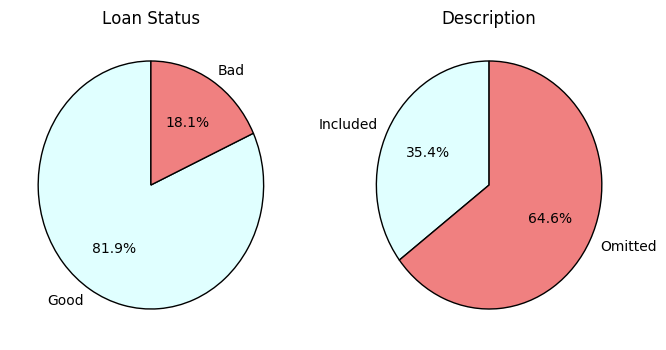

In [16]:
# plot description-related variables as pie charts
n, p = data.shape
fig = plt.figure(figsize = (8, 4))

# loan status
num_good = (data["loan_status"] == True).sum()
num_bad = n - num_good
pie_1 = fig.add_subplot(121)
pie_1.pie([num_good, num_bad], 
          labels = ["Good", "Bad"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_1.set_title("Loan Status")

# description included
num_include = (data["description"].notnull()).sum()
num_omit = n - num_include
pie_3 = fig.add_subplot(122)
pie_3.pie([num_include, num_omit], 
          labels = ["Included", "Omitted"],
          colors = ["lightcyan", "lightcoral"],
         autopct = "%1.1f%%", startangle = 90)
pie_3.set_title("Description")

plt.show()

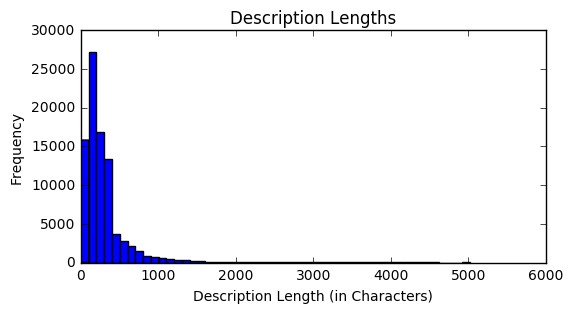

In [17]:
# visualize description lengths in characters
fig = plt.figure(figsize = (6, 3))

description_flags = data["description"].notnull()
descriptions = data.ix[description_flags, "description"]
description_lengths = descriptions.str.len()
data['desc_len'] = description_lengths
ax1 = fig.add_subplot(111)
ax1.hist(description_lengths, bins = 50)
ax1.set_title("Description Lengths")
ax1.set_xlabel("Description Length (in Characters)")
ax1.set_ylabel("Frequency")

plt.show()

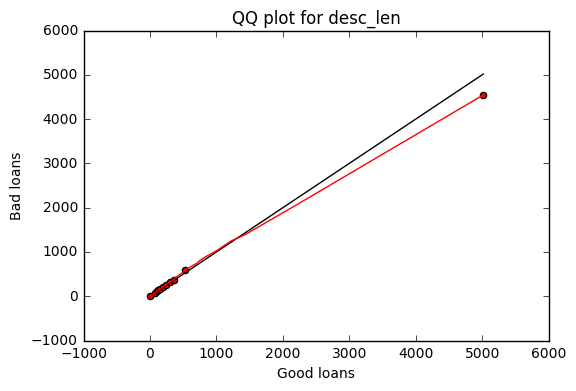

In [18]:
data_desc = data[description_flags]
good_bad_quantile_plot(data_desc, 'desc_len')

In [19]:
description_lengths_df = pd.DataFrame(description_lengths)
description_lengths_df.columns = ["description_length_chars"]
description_lengths_df.describe()

,description_length_chars
count,87830.000000
mean,291.893078
std,313.937304
min,1.000000
25%,120.000000
50%,206.000000
75%,342.000000
max,5016.000000


In [20]:
# Are descriptions correlated with inclusion of descriptions?
data_corr = pd.concat((data["loan_status"], description_flags), axis = 1)
corr_matrix = np.corrcoef(data_corr.T)

print
print "Loan status is not correlated with the inclusion of descriptions:\n"
print corr_matrix
print


Loan status is not correlated with the inclusion of descriptions:

[[ 1.          0.01892041]
 [ 0.01892041  1.        ]]



In [21]:
# extract loan description and status, and create n-grams from description

# extract and pre-process loan description and loan_status for NLP
data_extract = data[["description", "loan_status", "desc_len"]].copy()
data_extract["description"] = data_extract["description"].str.replace("Borrower.* > ", "")
data_nlp = data_extract.loc[description_flags, :].copy()

# create n-grams from loan description
vectorizer = CountVectorizer(stop_words = 'english', \
                             ngram_range = (3, 3))
desc_matrix = vectorizer.fit_transform(data_nlp['description'].values)
n, p = desc_matrix.shape

In [22]:
# apply SVD to document-term matrix
tsvd = tSVD(n_components = 10)
desc_matrix_reduce = tsvd.fit_transform(desc_matrix)

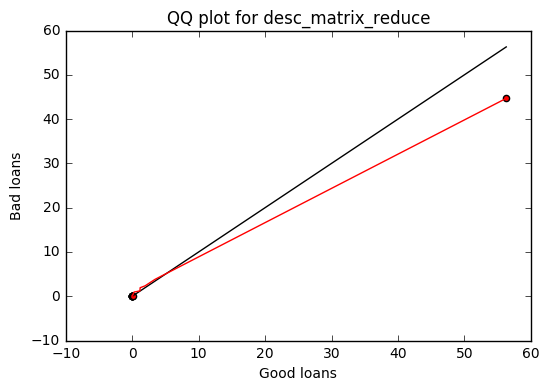

In [23]:
data_nlp['desc_matrix_reduce'] = desc_matrix_reduce[:, 0]
good_bad_quantile_plot(data_nlp, 'desc_matrix_reduce')

In [24]:
# print descriptive information about n-grams
feature_names = np.array(vectorizer.get_feature_names()).reshape(-1, 1)
print "Number of descriptions and terms:", n, p
print
print "Sample terms:", 
pd.DataFrame(feature_names[:10, 0])

Number of descriptions and terms: 87830 813322

Sample terms:

,0
0,__________________ br _number_
1,__________________ br rent
2,___________________________________ br br
3,_all territories_ st
4,_far_ thinner comparison
5,_number_ _number_ _number_
6,_number_ _number_ _number_a
7,_number_ _number_ _number_am
8,_number_ _number_ _number_apr
9,_number_ _number_ _number_apy


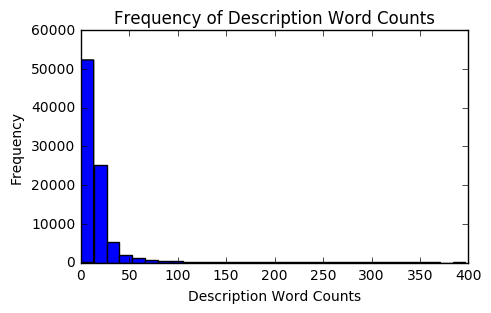

In [25]:
data_nlp['desc_word_count'] = desc_matrix.sum(axis = 1)

# plot histogram of word counts by description
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['desc_word_count'].values, bins = 30)
ax.set_title("Frequency of Description Word Counts")
ax.set_xlabel("Description Word Counts")
ax.set_ylabel("Frequency")
plt.show()

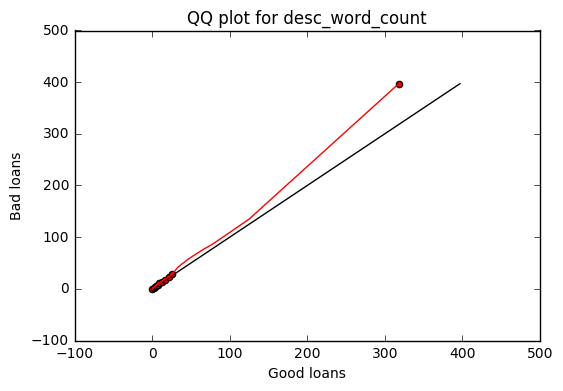

In [26]:
good_bad_quantile_plot(data_nlp, "desc_word_count")

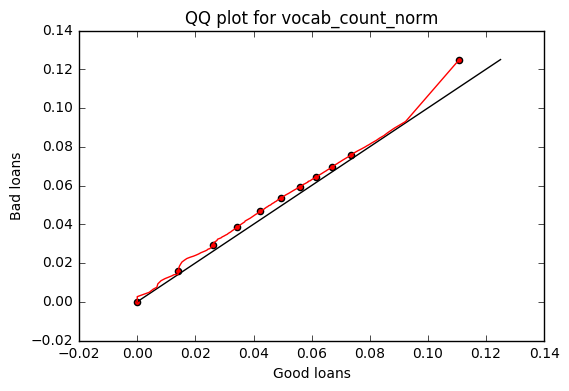

In [27]:
data_nlp['vocab_count'] = (desc_matrix > 0).sum(axis=1)

data_nlp['vocab_count_norm'] = data_nlp['vocab_count'] \
    / data_nlp['desc_len'].astype(float) 
good_bad_quantile_plot(data_nlp, "vocab_count_norm")

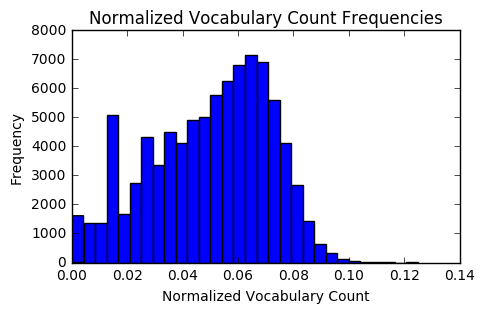

In [28]:
# plot histogram of vocabulary richness
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['vocab_count_norm'], bins = 30)
ax.set_title("Normalized Vocabulary Count Frequencies")
ax.set_xlabel("Normalized Vocabulary Count")
ax.set_ylabel("Frequency")
plt.show()

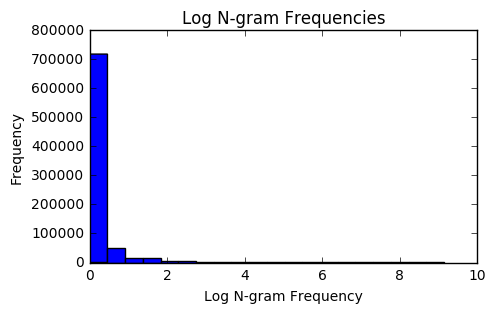

In [29]:
ngram_counts = np.log(desc_matrix.sum(axis = 0))

# plot histogram of n-gram frequency
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(ngram_counts.transpose(), bins = 20)
ax.set_title("Log N-gram Frequencies")
ax.set_xlabel("Log N-gram Frequency")
ax.set_ylabel("Frequency")
plt.show()

In [30]:
# split term matrix into defaulted vs. fully repaid
mask = data_nlp["loan_status"].values == False
bad_term_matrix = desc_matrix[mask]
good_term_matrix = desc_matrix[~mask]

all_term_dict = zip(vectorizer.get_feature_names(),
    np.asarray(desc_matrix.sum(axis = 0)).ravel())
all_term_dict_df = pd.DataFrame(all_term_dict).sort_values(by = [1], \
                                                                   ascending = False)
bad_term_dict = zip(vectorizer.get_feature_names(),
    np.asarray(bad_term_matrix.sum(axis = 0)).ravel())
bad_term_dict_df = pd.DataFrame(bad_term_dict).sort_values(by = [1], \
                                                                   ascending = False)
good_term_dict = zip(vectorizer.get_feature_names(),
    np.asarray(good_term_matrix.sum(axis = 0)).ravel())
good_term_dict_df = pd.DataFrame(good_term_dict).sort_values(by = [1], \
                                                                 ascending = False)

top_bad_dict_df = bad_term_dict_df.iloc[:125, :]
top_good_dict_df = good_term_dict_df.iloc[:125, :]

bad_only_df = pd.DataFrame(list(set(top_bad_dict_df[0]) - set(top_good_dict_df[0])))
good_only_df = pd.DataFrame(list(set(top_good_dict_df[0]) - set(top_bad_dict_df[0])))

In [31]:
print
print "Most Frequent Terms in Descriptions of All Loans:"
all_term_dict_df.head(20)


Most Frequent Terms in Descriptions of All Loans:


,0,1
188915,credit card debt,9335
5,_number_ _number_ _number_,7203
546345,pay credit cards,5263
189978,credit cards br,4258
546342,pay credit card,3546
170801,consolidate credit card,2774
346529,high credit cards,2702
248,_number_ _number_ br,2410
211826,debt consolidation br,2297
170802,consolidate credit cards,2112


In [32]:
print
print "Most Frequent Terms Only in Descriptions of Defaulted Loans:"
bad_only_df


Most Frequent Terms Only in Descriptions of Defaulted Loans:


,0
0,pay debt br
1,credit cards make
2,lending club br
3,need pay credit
4,br _number_ _number_
5,loans credit cards
6,pay bills br
7,credit score br
8,consolidating credit cards
9,home improvements br


In [33]:
print
print "Most Frequent Terms Only in Descriptions of Fully Repaid Loans:"
good_only_df


Most Frequent Terms Only in Descriptions of Fully Repaid Loans:


,0
0,credit card balance
1,_number_ _number_ apr
2,balance _number_ _number_
3,credit cards higher
4,loan lower rate
5,_number_ years ago
6,looking consolidate credit
7,pay higher credit
8,cards high rates
9,using loan consolidate


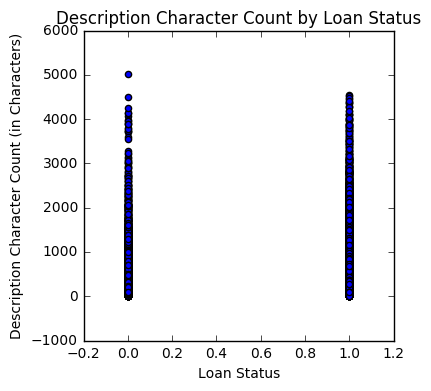

In [34]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_len'])
ax1.set_title("Description Character Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Character Count (in Characters)")
plt.show()

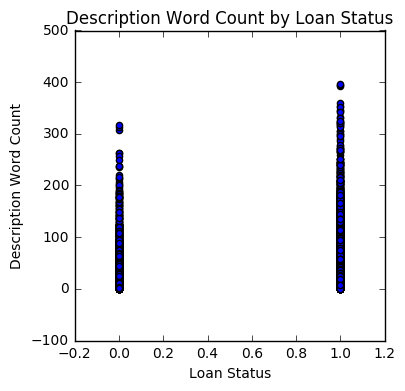

In [35]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['desc_word_count'])
ax1.set_title("Description Word Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Description Word Count")
plt.show()

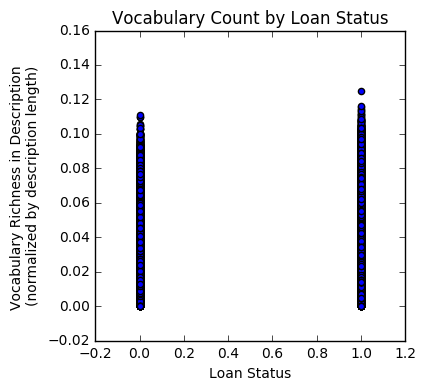

In [162]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['vocab_count_norm'])
ax1.set_title("Vocabulary Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Vocabulary Richness in Description \n(normalized by description length)")
plt.show()

In [163]:
### count misspellings

d = enchant.Dict("en_US")

num_terms = all_term_dict_df.shape[0]
misspellings = np.zeros(num_terms)
for index in range(num_terms):
    misspellings[index] = not d.check(all_term_dict_df.iloc[index, 0])

desc_matrix_misspell = desc_matrix[:, misspellings > 0]
data_nlp['misspell_count'] = desc_matrix_misspell.sum(axis=1)

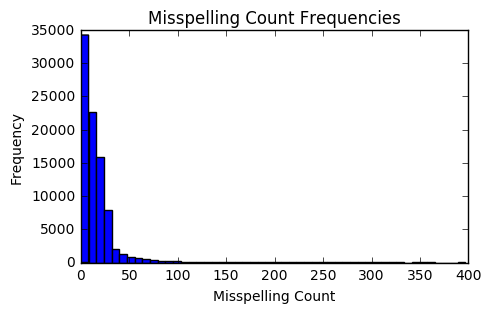

In [164]:
# plot histogram of misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count'], bins = 50)
ax.set_title("Misspelling Count Frequencies")
ax.set_xlabel("Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

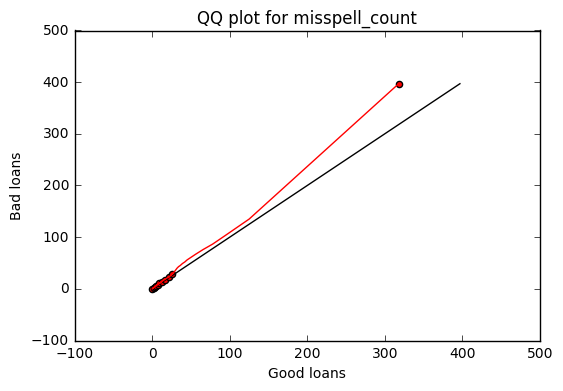

In [165]:
good_bad_quantile_plot(data_nlp, "misspell_count")

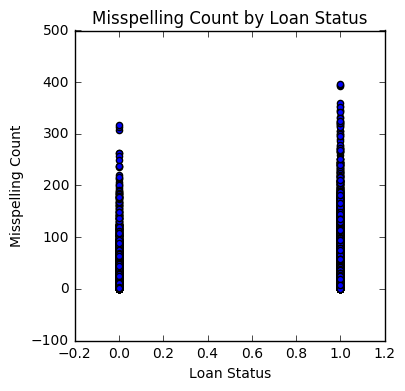

In [166]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count'])
ax1.set_title("Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Misspelling Count")
plt.show()

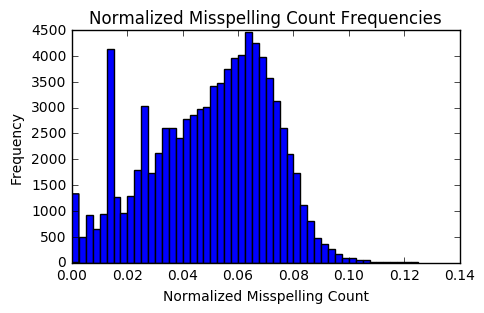

In [167]:
data_nlp['misspell_count_norm'] = data_nlp['misspell_count'] \
    / data_nlp['desc_len'].astype(float) 

# plot histogram of normalized misspelling counts
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp['misspell_count_norm'], bins = 50)
ax.set_title("Normalized Misspelling Count Frequencies")
ax.set_xlabel("Normalized Misspelling Count")
ax.set_ylabel("Frequency")
plt.show()

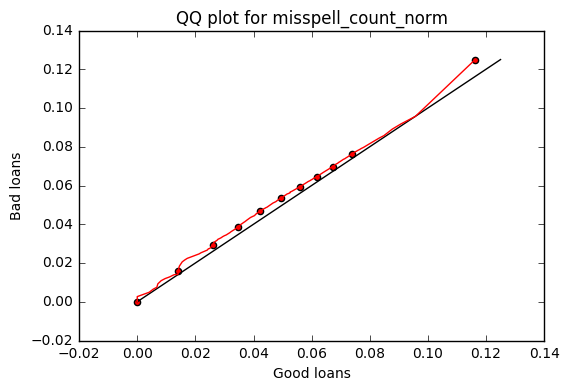

In [168]:
good_bad_quantile_plot(data_nlp, "misspell_count_norm")

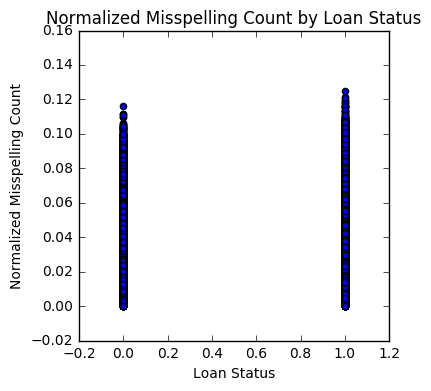

In [169]:
fig = plt.figure(figsize = (4, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(data_nlp['loan_status'], data_nlp['misspell_count_norm'])
ax1.set_title("Normalized Misspelling Count by Loan Status")
ax1.set_xlabel("Loan Status")
ax1.set_ylabel("Normalized Misspelling Count")
plt.show()

## Step 3: Model Data

In [170]:
# use description column, desctiption lengths, n-grams, and KNN 
#    to predict defaults and score accuracy

# use KNN with cross-validation to train and score models predicting loan defaults
# TO DO: tune parameters k for KNN and n for n-grams

score_accum_knn = np.zeros((2, 2))
num_iters = 50
for i in range(num_iters):
    mask = np.random.rand(n) < 0.8

    train_y = data_nlp["loan_status"][mask]
    test_y = data_nlp["loan_status"][~mask]

    train_x = desc_matrix[mask]
    test_x = desc_matrix[~mask]  

    model_knn = KNN(n_neighbors = 5)
    model_knn.fit(train_x, train_y)
    y_predict = model_knn.predict(test_x)
    score_accum_knn += confusion_matrix(test_y, y_predict)

# compute prediction accuracy
score_knn = score_accum_knn / float(num_iters)
score_knn = score_knn.astype('float') / score_knn.sum(axis=1)[:, np.newaxis]
score_df_knn = pd.DataFrame(score_knn, \
                        columns = ["predicted_bad", "predicted_good"])
row_labels = pd.DataFrame(["actual_bad", "actual_good"])
score_df_knn = pd.concat((row_labels, score_df_knn), axis = 1)
overall_accuracy_knn = round((score_df_knn.ix[0, 1] + score_df_knn.ix[1, 2]) / 2.0, 4)

KeyboardInterrupt: 

In [171]:
print "Overall accuracy with KNN:", overall_accuracy_knn
print
print "Confusion Matrix:"
score_df_knn

Overall accuracy with KNN: 0.5031

Confusion Matrix:


,0,predicted_bad,predicted_good
0,actual_bad,0.059393,0.940607
1,actual_good,0.053098,0.946902


In [172]:
# # use description column with logistic regression to predict defaults and score accuracy

# desc_len_ar = description_lengths.reshape(-1, 1)
# desc_matrix_norm = desc_matrix_reduce / desc_len_ar.astype(float)

In [36]:
# use logistic regression with cross-validation to train and score models
# predicting loan defaults
n = data_nlp.shape[0]
score_accum_lr = np.zeros((2, 2))
num_iters = 50
for i in range(num_iters):
    mask = np.random.rand(n) < 0.80

    train_y = data_nlp["loan_status"][mask]
    test_y = data_nlp["loan_status"][~mask]

    train_x = desc_matrix[mask]
    test_x = desc_matrix[~mask]

    model_lr = Log_Reg(C = 1, class_weight = 'balanced')
    model_lr.fit(train_x, train_y)
    y_predict = model_lr.predict(test_x)
    score_accum_lr += confusion_matrix(test_y, y_predict)

# compute prediction accuracy
score_lr = score_accum_lr / float(num_iters)
score_lr = score_lr.astype('float') / score_lr.sum(axis=1)[:, np.newaxis]
score_df_lr = pd.DataFrame(score_lr, \
                        columns = ["predicted_bad", "predicted_good"])
row_labels = pd.DataFrame(["actual_bad", "actual_good"])
score_df_lr = pd.concat((row_labels, score_df_lr), axis = 1)
overall_accuracy_lr = round((score_df_lr.ix[0, 1] + score_df_lr.ix[1, 2]) / 2.0, 4)

In [174]:
print
print "Overall accuracy with logistic regression:", overall_accuracy_lr
print
print "Confusion Matrix:"
score_df_lr


Overall accuracy with logistic regression: 0.5163

Confusion Matrix:


,0,predicted_bad,predicted_good
0,actual_bad,0.126679,0.873321
1,actual_good,0.094119,0.905881


In [175]:
# # use description column with LDA to predict defaults and score accuracy
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# # use LDA with cross-validation to train and score models
# # predicting loan defaults
# score_accum = 0
# num_iters = 1
# for i in range(num_iters):
#     mask = np.random.rand(n) < 0.8

#     train_y = data_nlp["loan_status"][mask]
#     test_y = data_nlp["loan_status"][~mask]

#     train_x = desc_matrix[mask]
#     test_x = desc_matrix[~mask]  

#     model = LDA()
#     model.fit(train_x.toarray(), train_y)
#     score_accum += model.score(test_x, test_y)

# # print prediction accuracy
# score = score_accum / float(num_iters)
# print "Accuracy of predicting defaults from descriptions with LDA:", round(score, 2)

In [ ]:
# # use description column with QDA to predict defaults and score accuracy
# from sklearn.qda import QDA

# # use QDA with cross-validation to train and score models
# # predicting loan defaults
# score_accum = 0
# num_iters = 1
# for i in range(num_iters):
#     mask = np.random.rand(n) < 0.8

#     train_y = data_nlp["loan_status"][mask]
#     test_y = data_nlp["loan_status"][~mask]
# # 
#     train_x = desc_matrix[mask]
#     test_x = desc_matrix[~mask]  

#     model = QDA()
#     model.fit(train_x, train_y)
#     score_accum += model.score(test_x, test_y)

# # print prediction accuracy
# score = score_accum / float(num_iters)
# print "Accuracy of predicting defaults from descriptions with QDA:", round(score, 2)

In [ ]:
# use description column with random forests to predict defaults and score accuracy
from sklearn.ensemble import RandomForestClassifier as RFC

# use random forests with cross-validation to train and score models
# predicting loan defaults
score_accum_rf = 0
num_iters = 1
for i in range(num_iters):
    mask = np.random.rand(n) < 0.8

    train_y = data_nlp["loan_status"][mask]
    test_y = data_nlp["loan_status"][~mask]

    train_x = desc_matrix[mask]
    test_x = desc_matrix[~mask]  

    model_rf = RFC()
    model_rf.fit(train_x, train_y)
    y_predict = model_rf.predict(test_x)
    score_accum_rf += confusion_matrix(test_y, y_predict)

# compute prediction accuracy
score_rf = score_accum_rf / float(num_iters)
score_rf = score_rf.astype('float') / score_rf.sum(axis=1)[:, np.newaxis]
score_df_rf = pd.DataFrame(score_rf, \
                        columns = ["predicted_bad", "predicted_good"])
row_labels = pd.DataFrame(["actual_bad", "actual_good"])
score_df_rf = pd.concat((row_labels, score_df_rf), axis = 1)
overall_accuracy_rf = round((score_df_rf.ix[0, 1] + score_df_rf.ix[1, 2]) / 2.0, 4)

In [ ]:
print "Overall accuracy with logistic regression:", overall_accuracy_rf
print
print "Confusion Matrix:"
score_df_rf